# Table of Contents
 <p><div class="lev1"><a href="#Reading-data"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reading data</a></div><div class="lev1"><a href="#Global-descriptors"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global descriptors</a></div><div class="lev1"><a href="#Grantham-descriptor"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grantham descriptor</a></div>

# Reading data

In [65]:
from modlamp.descriptors import GlobalDescriptor, PeptideDescriptor
import pandas as pd
from pandas import Series
import numpy as np



data = pd.read_csv("atm40_overall_sequen.csv")
data.head()
#data.sort_values(by=['ec50'], ascending=True)


,Code,sequences,ec50,round,acitivity
0,CN-10,VKAWAKVLKGFGKLLKGFGKL,6.15,0,1
1,CN-32,VKAWPRLLKGYGRFIKGYGKY,100.00,1,3
2,CN-33,IKAWAKVLRGFGKLFKGWGKL,5.20,1,1
3,CN-34,VKPWAHVIKGYGKLLKGYGRF,100.00,1,3
4,CN-35,VKAWARVLKGIGKFYKGFGKI,30.53,1,2


# Global descriptors

In [66]:
desc = GlobalDescriptor(data["sequences"].tolist())

In [67]:
desc.charge_density()

In [68]:
desc.hydrophobic_ratio(append=True)

In [69]:
desc2 = PeptideDescriptor(data["sequences"].tolist(), 'eisenberg')

In [70]:
desc2.calculate_moment()

In [71]:
desc2.calculate_global(append=True)

In [72]:
desc2.load_scale("charge_acid")
desc2.calculate_global(append=True)
desc2.calculate_moment(append=True)

In [73]:

X = np.hstack((desc.descriptor,desc2.descriptor))

In [74]:
X.shape


(31, 6)

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scl = StandardScaler()
Xt = scl.fit_transform(X)

In [76]:
data['Charge_density'] = Series(Xt[:,0], index=data.index)
data['Hydroph_ratio'] = Series(Xt[:,1], index=data.index)
data['Hydroph_moment'] = Series(Xt[:,2], index=data.index)
data['Global_hydroph'] = Series(Xt[:,3], index=data.index)
data['Global_charge'] = Series(Xt[:,4], index=data.index)
data['Charge_moment'] = Series(Xt[:,5], index=data.index)

In [77]:
y1 = data.as_matrix(columns=["ec50"])

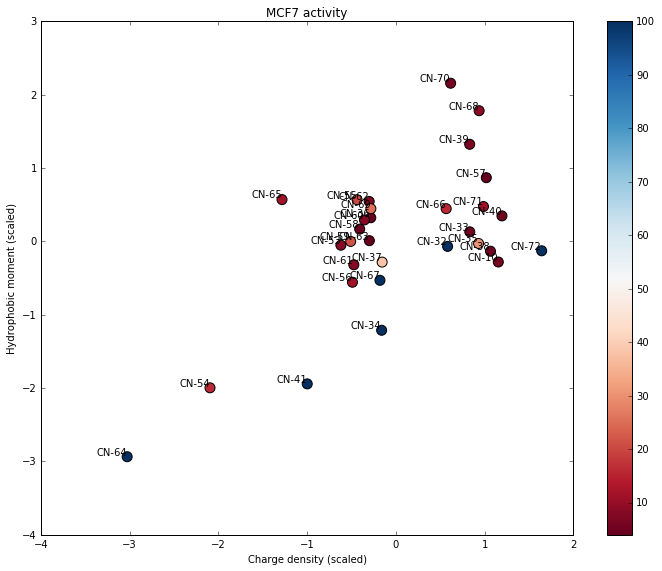

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

# Choose descriptor here
dsc1 = 0
dsc1_name = "Charge density (scaled)"
dsc2 = 2
dsc2_name = "Hydrophobic moment (scaled)"

plt.figure(figsize=(10,8))


im1 = plt.scatter(Xt[:,dsc1],Xt[:,dsc2], c=y1, cmap='RdBu',s=100)
plt.xlabel(dsc1_name)
plt.ylabel(dsc2_name)
plt.title("MCF7 activity")

for label, x, y in zip(data["Code"].tolist(),Xt[:,dsc1],Xt[:,dsc2]):
    plt.annotate(
    label,
    xy=(x,y), xytext=(-0.1,-0.1),
    textcoords='offset points', ha='right', va='bottom')
    #bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
    #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0'))
cbar1 = plt.colorbar(im1, orientation='vertical',shrink=1)

plt.tight_layout()
#plt.savefig("Activity_landscapes2.pdf",dpi=600, device="pdf")
plt.show()

# Grantham descriptor

In [79]:
from modlamp import descriptors as dct
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

sequences = data["sequences"].tolist()

scalename = 'grantham'

descCalc = dct.PeptideDescriptor(sequences, scalename)
descCalc.calculate_autocorr(1)

descr = descCalc.descriptor

scl = StandardScaler()
descr_scl = scl.fit_transform(descr)

print descr.shape

(31, 3)


In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
descr_pca = pca.fit_transform(descr_scl)
print pca.components_
print pca.explained_variance_ratio_

[[-0.68429172  0.62114063 -0.38200677]
 [-0.08284893  0.45424902  0.88701402]]
[ 0.60012192  0.30417   ]


In [81]:
Xt=descr_pca

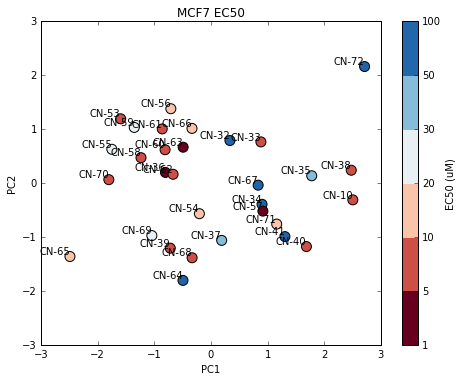

In [82]:
#%matplotlib inline
import matplotlib
from matplotlib import colors
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

dsc1 = 0
dsc1_name = "PC1"
dsc2 = 1
dsc2_name = "PC2"

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(241)

bounds = np.array([1, 5, 10, 20, 30, 50, 100])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=230)

im1 = ax.scatter(Xt[:,dsc1],Xt[:,dsc2], c=y1, norm=norm, cmap='RdBu',s=100)
ax.set_xlabel(dsc1_name)
ax.set_ylabel(dsc2_name)
ax.set_title("MCF7 EC50")

for label, x, y in zip(data["Code"].tolist(),Xt[:,dsc1],Xt[:,dsc2]):
    ax.annotate(
    label,
    xy=(x,y), xytext=(0,0),
    textcoords='offset points', ha='right', va='bottom')
    #bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
    #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=0'))
cbar1 = plt.colorbar(im1, orientation='vertical',shrink=1)
cbar1.ax.set_ylabel('EC50 (uM)')
    

plt.tight_layout()
#plt.savefig("Activity_landscapes2.pdf",dpi=600, device="pdf")
plt.show()

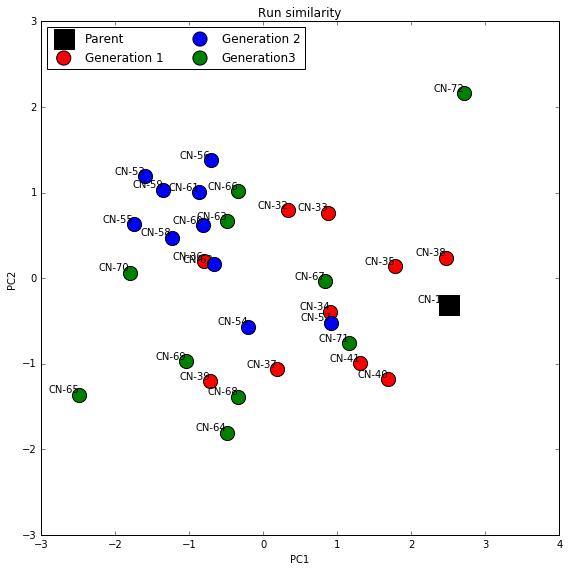

In [83]:
fig = plt.figure(figsize=(8,8))
parent = plt.scatter(Xt[0,dsc1],Xt[0,dsc2], c="black", marker='s', s=400)
run1 = plt.scatter(Xt[1:11,dsc1],Xt[1:11,dsc2], c="red", s=200)
run2 = plt.scatter(Xt[11:21,dsc1],Xt[11:21,dsc2], c="blue", s=200)
run3 = plt.scatter(Xt[21:,dsc1],Xt[21:,dsc2], c="green", s=200)
for label, x, y in zip(data["Code"].tolist(),Xt[:,dsc1],Xt[:,dsc2]):
    plt.annotate(
    label,
    xy=(x,y), xytext=(0,0),
    textcoords='offset points', ha='right', va='bottom')
plt.xlabel(dsc1_name)
plt.ylabel(dsc2_name)
plt.title("Run similarity")
plt.legend((parent,run1, run2, run3),
           ('Parent', 'Generation 1', 'Generation 2', 'Generation3'),
           scatterpoints=1,
           loc='upper left',
           ncol=2,
           fontsize=12)

plt.tight_layout()
plt.show()